In [2]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import pickle
import gc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import catboost as cb
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Train/test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [3]:
# Will we save intermediate models?
save_models = True

In [4]:
all_data = pd.read_parquet('data/all_data.parquet')
# print('Columns:', all_data.columns)
all_data.info()
all_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 0 to 6639293
Data columns (total 84 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   shop_id                                int32  
 1   item_id                                int32  
 2   date_block_num                         int32  
 3   item_category_id                       int32  
 4   target                                 float32
 5   target_shop                            float32
 6   target_item                            float32
 7   target_item_shop                       float32
 8   target_item_category                   float32
 9   target_shop_item_category              float32
 10  target_mean                            float32
 11  target_shop_mean                       float32
 12  target_item_mean                       float32
 13  target_item_shop_mean                  float32
 14  target_item_category_mean              float32
 15

,shop_id,item_id,date_block_num,item_category_id,target,target_shop,target_item,target_item_shop,target_item_category,target_shop_item_category,...,target_shop_item_category_mean_lag_12,target_shop_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
0,59,944,12,37,1.0,1491.0,23.0,1.0,7511.0,104.0,...,8.988200,2017.0,30,11,1,0,0,0,31,0.000000
1,59,21861,12,37,1.0,1491.0,62.0,1.0,7511.0,104.0,...,8.988200,2017.0,30,11,1,0,0,0,31,0.000000
2,59,21455,12,37,1.0,1491.0,20.0,1.0,7511.0,104.0,...,8.988200,2017.0,30,11,1,0,0,0,31,0.000000
3,59,33,12,37,2.0,1491.0,42.0,2.0,7511.0,104.0,...,8.988200,2017.0,30,11,1,0,0,0,31,0.000000
4,59,19750,12,37,1.0,1491.0,8.0,1.0,7511.0,104.0,...,8.988200,2017.0,30,11,1,0,0,0,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639289,45,18454,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,20,13,2,10,11,11,30,-0.475305
6639290,45,16188,34,64,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,20,14,42,10,2,2,30,0.081167
6639291,45,15757,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,12.416455,1251.0,20,13,2,10,22,22,30,0.155905
6639292,45,19648,34,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,20,11,4,10,11,11,30,-0.091709


In [5]:
# list(all_data.columns)

In [6]:
# List of all lagged features

# We will drop these at fitting stage
to_drop_cols = ['target_shop', 'target_item', 'target_item_mean', 'target_mean', 
                'target_item_shop', 'target', 'target_shop_mean', 'target_item_shop_mean', 
                'date_block_num']

# Categorical features
cat_features = ['shop_id', 'item_id', 'item_category_id', 'city_code', 
                'type_code', 'subtype_code']

In [7]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()-1
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [8]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train =  all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =   all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)
X_target = all_data.loc[dates == dates.max()].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

In [9]:
X_train

,shop_id,item_id,item_category_id,target_item_category,target_shop_item_category,target_item_category_mean,target_shop_item_category_mean,target_lag_1,target_item_lag_1,target_item_category_lag_1,...,target_shop_item_category_mean_lag_12,target_shop_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
0,59,944,37,7511.0,104.0,8.909845,8.909845,0.0,24.0,9959.0,...,8.9882,2017.0,30,11,1,0,0,0,31,0.000000
1,59,21861,37,7511.0,104.0,8.909845,8.909845,0.0,28.0,9959.0,...,8.9882,2017.0,30,11,1,0,0,0,31,0.000000
2,59,21455,37,7511.0,104.0,8.909845,8.909845,1.0,12.0,9959.0,...,8.9882,2017.0,30,11,1,0,0,0,31,0.000000
3,59,33,37,7511.0,104.0,8.909845,8.909845,0.0,42.0,9959.0,...,8.9882,2017.0,30,11,1,0,0,0,31,0.000000
4,59,19750,37,7511.0,104.0,8.909845,8.909845,0.0,15.0,9959.0,...,8.9882,2017.0,30,11,1,0,0,0,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6186917,55,5230,26,9.0,9.0,4.500000,4.500000,1.0,1.0,6.0,...,0.0000,0.0,27,6,61,7,8,8,31,0.058935
6186918,55,2757,26,9.0,9.0,4.500000,4.500000,4.0,4.0,6.0,...,0.0000,0.0,27,6,61,7,8,8,31,-0.031505
6186919,55,7115,27,1.0,1.0,1.000000,1.000000,0.0,0.0,0.0,...,0.0000,0.0,27,7,61,7,0,0,31,0.000000
6186920,55,13095,36,5.0,5.0,2.500000,2.500000,0.0,0.0,0.0,...,0.0000,0.0,27,9,15,7,0,0,31,0.000000


In [10]:
del all_data
gc.collect()

82

# First level models 

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first. 

### Test meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the last month.

In [8]:
model_lr = LinearRegression()
model_lr.fit(X_train.values, y_train)
pred_lr = model_lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))
print('Test RMSE linreg is %f' % np.sqrt(mean_squared_error(y_test, pred_lr)))
# model_lr.to_pickle('data/se-model_lr.pkl', compression='bz2')

Test R-squared for linreg is 0.507441
Test RMSE linreg is 1.891999


In [9]:
if save_models:
    pickle.dump(model_lr, open('data/sa-model_lr.pkl', "wb"))

And the we run *LightGBM*.

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.31428
[200]	valid_0's l2: 2.15913
[300]	valid_0's l2: 2.08434
[400]	valid_0's l2: 2.06787
[500]	valid_0's l2: 2.07552
[600]	valid_0's l2: 2.04121
[700]	valid_0's l2: 2.03539
[800]	valid_0's l2: 2.01722
[900]	valid_0's l2: 2.01255
Early stopping, best iteration is:
[892]	valid_0's l2: 2.0081
Test R-squared for LightGBM is 0.723687
Test RMSE LightGBM is 1.417073
CPU times: user 19min 19s, sys: 10.1 s, total: 19min 30s
Wall time: 5min 19s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

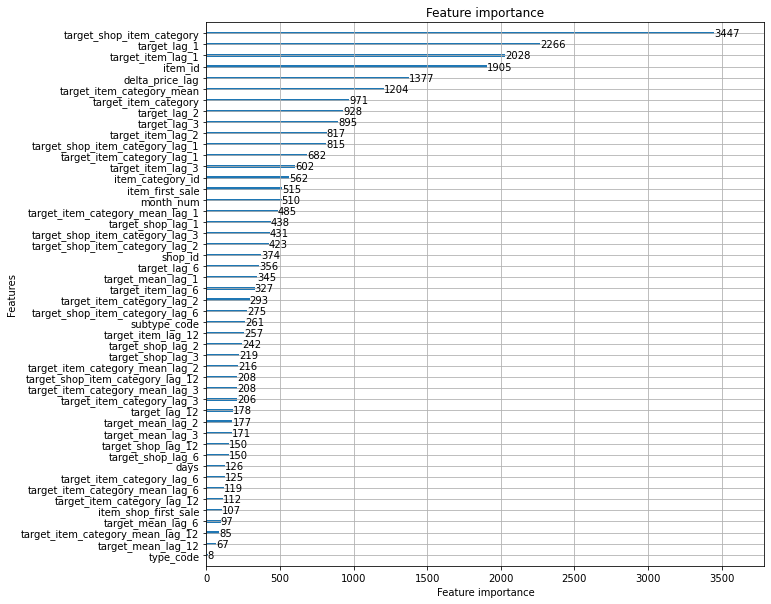

In [10]:
%%time
# LightGGM
model_lgb = lgb.LGBMRegressor(
    n_estimators=1000,
    n_jobs=-1,
    objective='mse',
    random_state=17
)
model_lgb.fit(X_train, y_train, 
              eval_set=(X_test, y_test), 
              early_stopping_rounds=100,
              verbose=100)
pred_lgb = model_lgb.predict(X_test)

print('\nTest R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))
print('Test RMSE LightGBM is %f' % np.sqrt(mean_squared_error(y_test, pred_lgb)))
print()

# Plot LightGBM features importance
fig, ax = plt.subplots(1,1,figsize=(10, 10))
lgb.plot_importance(booster=model_lgb, ax=ax)

In [11]:
if save_models:
    pickle.dump(model_lgb, open('data/sa-model_lgb.pkl', "wb"))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.239925
0:	learn: 3.1506063	test: 2.5161579	best: 2.5161579 (0)	total: 5.19s	remaining: 1h 26m 21s
20:	learn: 1.7667163	test: 1.6346285	best: 1.6320193 (19)	total: 1m 46s	remaining: 1h 22m 54s
40:	learn: 1.6128064	test: 1.5732228	best: 1.5727824 (39)	total: 3m 27s	remaining: 1h 21m 4s
60:	learn: 1.5137975	test: 1.5907373	best: 1.5627251 (43)	total: 5m 13s	remaining: 1h 20m 27s
80:	learn: 1.4641817	test: 1.5688731	best: 1.5627251 (43)	total: 6m 56s	remaining: 1h 18m 41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.562725138
bestIteration = 43

Shrink model to first 44 iterations.
Test R-squared for CatBoost is 0.663968
Test RMSE CatBoost is 1.562725
CPU times: user 28min 31s, sys: 1min 2s, total: 29min 34s
Wall time: 8min 22s


<AxesSubplot:title={'center':'Feature importances'}, ylabel='Feature Id'>

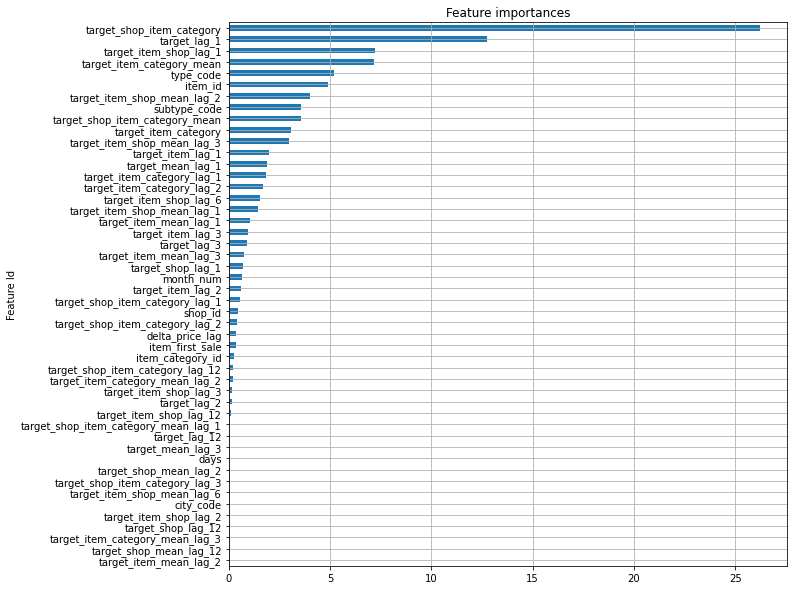

In [12]:
%%time
# Catboost

model_cbr = cb.CatBoostRegressor(loss_function='RMSE',
                                 cat_features=cat_features,
                                 iterations=1000,
                                task_type='CPU')
model_cbr.fit(X_train, y_train, 
              eval_set=(X_test, y_test), 
              verbose=20, 
              early_stopping_rounds=50,
              plot=True)
pred_cb = model_cbr.predict(X_test)

print('\nTest R-squared for CatBoost is %f' % r2_score(y_test, pred_cb))
print('Test RMSE CatBoost is %f' % np.sqrt(mean_squared_error(y_test, pred_cb)))
print()

# Plot CatBoost features importance
f_importance = model_cbr.get_feature_importance(prettified=True)
f_importance[f_importance['Importances']>0].sort_values(by='Importances', ascending=True).set_index('Feature Id').plot(
    kind='barh', figsize=(10,10), legend=False, grid=True, title="Feature importances");

In [13]:
if save_models:
    pickle.dump(model_cbr, open('data/sa-model_cbr.pkl', "wb"))

In [14]:
# SVM
# model_svr = SVR()
# model_svr.fit(X_train.values, y_train)
# pred_svr = model_svr.predict(X_test.values, verbose=True)

# print('Test R-squared for SVR is %f' % r2_score(y_test, pred_svr))
# print('Test RMSE SVR is %f' % np.sqrt(mean_squared_error(y_test, pred_svr)))

[10:03:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:2.31489
Will train until validation_0-rmse hasn't improved in 30 rounds.
[10]	validation_0-rmse:1.77199
[20]	validation_0-rmse:1.63991
[30]	validation_0-rmse:1.54169
[40]	validation_0-rmse:1.53133
[50]	validation_0-rmse:1.62765
[60]	validation_0-rmse:1.68546
[70]	validation_0-rmse:1.69602
Stopping. Best iteration:
[43]	validation_0-rmse:1.52784

Test R-squared for XGBoost is 0.678788
Test RMSE XGBoost is 1.527875
CPU times: user 1h 30min 30s, sys: 48.2 s, total: 1h 31min 18s
Wall time: 25min 45s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

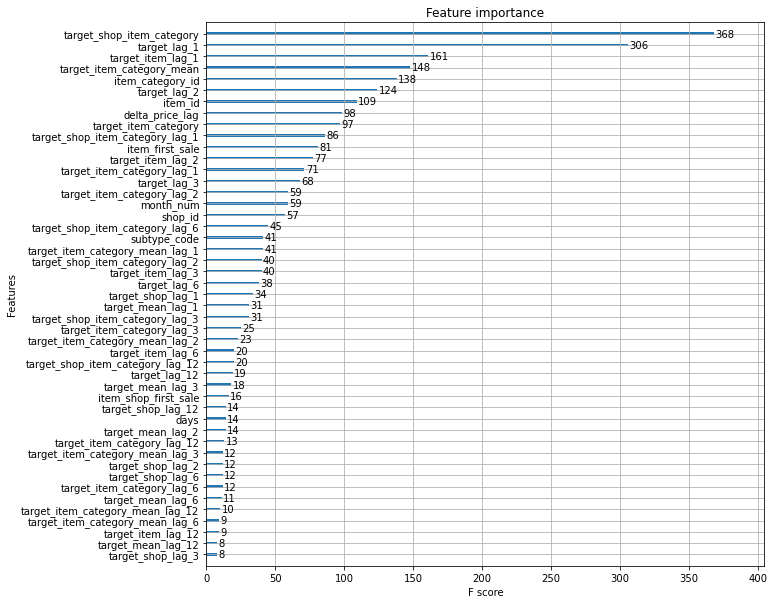

In [15]:
%%time
# XGBM
model_xgb = xgb.XGBRegressor(n_estimators=500, n_jobs=4, random_state=17)
model_xgb.fit(X_train, y_train, 
              eval_set=[(X_train, y_train), (X_test, y_test)], 
              eval_metric="rmse", 
              verbose=10, 
              early_stopping_rounds = 30)
pred_xgb = model_xgb.predict(X_test)

print('\nTest R-squared for XGBoost is %f' % r2_score(y_test, pred_xgb))
print('Test RMSE XGBoost is %f' % np.sqrt(mean_squared_error(y_test, pred_xgb)))
print()

# Plot XGBoost features importance
fig, ax = plt.subplots(1,1,figsize=(10, 10))
xgb.plot_importance(booster=model_xgb, ax=ax)

In [16]:
if save_models:
    pickle.dump(model_xgb, open('data/sa-model_xgb.pkl', "wb"))

Finally, concatenate test predictions to get test meta-features.

## Load pickled predictors 

In [11]:
# Load pickled predictors
if save_models:
    model_lr  = pickle.load(open('data/sa-model_lr.pkl', "rb"))
    model_lgb = pickle.load(open('data/sa-model_lgb.pkl', "rb"))
    model_cbr = pickle.load(open('data/sa-model_cbr.pkl', "rb"))
    model_xgb = pickle.load(open('data/sa-model_xgb.pkl', "rb"))

In [12]:
%%time
# Make predictions for test data
train_lr  = model_lr.predict(X_train)
train_lgb = model_lgb.predict(X_train)
train_cbr = model_cbr.predict(X_train)
train_xgb = model_xgb.predict(X_train)

X_train_level2 = np.c_[train_lr, train_lgb, train_cbr, train_xgb] 
# X_test_level2.tofile('X_test_level2')

CPU times: user 4min 51s, sys: 7.11 s, total: 4min 58s
Wall time: 1min 35s


In [13]:
print('Train L2 data shape:', X_train_level2.shape)
X_train_level2

Train L2 data shape: (6186922, 4)


array([[ 0.21143949,  0.26387745,  0.44552443,  0.24341372],
       [-0.03085692,  0.2609846 ,  0.37044505,  0.35931846],
       [ 0.35971461,  0.10826642,  0.10297126,  0.13501653],
       ...,
       [ 0.06162763,  0.37464666,  0.66010081,  0.16706198],
       [ 0.13936958,  0.5553193 ,  0.2166174 ,  0.1421982 ],
       [ 0.1393701 ,  0.5553193 ,  0.2166174 ,  0.1421982 ]])

In [14]:
%%time
# Make predictions for test data (Kaggle's test dataset)
test_lr  = model_lr.predict(X_test)
test_lgb = model_lgb.predict(X_test)
test_cbr = model_cbr.predict(X_test)
test_xgb = model_xgb.predict(X_test)

X_test_level2 = np.c_[test_lr, test_lgb, test_cbr, test_xgb]

CPU times: user 12.6 s, sys: 381 ms, total: 13 s
Wall time: 3.85 s


In [15]:
print('Test L2 data shape:', X_test_level2.shape)
X_test_level2 client_max_body_size 1M

Test L2 data shape: (238172, 4)


array([[-0.07747169,  0.15673575,  0.12280534,  0.11584884],
       [ 0.02911684,  0.16282218,  0.11330731,  0.14050055],
       [ 0.14996053,  0.02766032,  0.06047194,  0.07649085],
       ...,
       [ 0.64180041,  1.00446102,  0.30352887,  0.29773879],
       [ 1.98694535,  2.46706406,  0.93592103,  1.50311351],
       [ 0.15594849,  0.97275708,  0.23898797,  0.1421982 ]])

In [16]:
%%time
# Make prediction for target data
target_lr  = model_lr.predict(X_target)
target_lgb = model_lgb.predict(X_target)
target_cbr  = model_cbr.predict(X_target)
target_xgb = model_xgb.predict(X_target)

X_target_level2 = np.c_[target_lr, target_lgb, target_cbr, target_xgb]

CPU times: user 10.9 s, sys: 244 ms, total: 11.1 s
Wall time: 3.28 s


In [17]:
print('Target L2 data shape:', X_target_level2.shape)
X_target_level2

Target L2 data shape: (214200, 4)


array([[-0.09421363, -0.21058467,  0.94571303,  0.23070341],
       [ 0.13399831,  0.05707526,  0.00885477,  0.09055156],
       [ 0.60826614,  0.91066696,  0.84499468,  0.19045517],
       ...,
       [-0.1633864 ,  0.01357033, -0.01881236, -0.03613734],
       [ 0.00663444, -0.01145119, -0.02880004, -0.04387718],
       [-0.12880094, -0.00601111, -0.04179542, -0.02322167]])

In [18]:
%%time
l2_model_lr = LinearRegression()
l2_model_lr.fit(X_train_level2, y_train)
test_l2_lr = l2_model_lr.predict(X_test_level2)

print(f'Test RMSE for LinearRegression L2 is {np.sqrt(mean_squared_error(y_test, test_l2_lr))}')

Test RMSE for LinearRegression L2 is 1.4167105134313587
CPU times: user 1.36 s, sys: 358 ms, total: 1.72 s
Wall time: 697 ms


In [19]:
%%time
l2_model_cb = cb.CatBoostRegressor(loss_function='RMSE',
                               task_type='CPU')
l2_model_cb.fit(X_train_level2, y=y_train,
             eval_set=(X_test_level2, y_test),
             early_stopping_rounds=50,
             verbose=20,
             plot=True)
test_l2_cbr = l2_model_cb.predict(X_test_level2)

print(f'Test RMSE for CatBoost L2 is {np.sqrt(mean_squared_error(y_test, test_l2_cbr))}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.239925
0:	learn: 3.3923288	test: 2.5821223	best: 2.5821223 (0)	total: 444ms	remaining: 7m 23s
20:	learn: 3.1737381	test: 2.4646696	best: 2.4586235 (7)	total: 8.31s	remaining: 6m 27s
40:	learn: 3.1714623	test: 2.4681637	best: 2.4586235 (7)	total: 16.6s	remaining: 6m 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.458623501
bestIteration = 7

Shrink model to first 8 iterations.
Test RMSE for CatBoost L2 is 2.4586235013455426
CPU times: user 1min 26s, sys: 4.7 s, total: 1min 31s
Wall time: 31.1 s


## Prepare data to Kaggle

In [98]:
# Make submission
tests = pd.read_csv('../readonly/final_project_data/test.csv.gz')
export_pred = l2_model_lr.predict(X_target_level2)

kaggle_data = tests.merge(
    pd.DataFrame(np.c_[X_target[['shop_id', 'item_id']], export_pred], 
                 columns=['shop_id', 'item_id', 'item_cnt_month']) )
kaggle_data['item_cnt_month'].clip(0, 20, inplace=True)

kaggle_data[['ID', 'item_cnt_month']].to_csv('simple_ensemble.csv', index=False)

print('kaggle_data shape:', kaggle_data.shape)
kaggle_data

kaggle_data shape: (214200, 4)


,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.000000
1,1,5,5320,0.037516
2,2,5,5233,1.096296
3,3,5,5232,0.084867
4,4,5,5268,0.138498
...,...,...,...,...
214195,214195,45,18454,0.012016
214196,214196,45,16188,0.000000
214197,214197,45,15757,0.032899
214198,214198,45,19648,0.000000
